In [35]:
#%pip install mlxtend

In [36]:
import onnx
import onnxruntime

import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import confusion_matrix, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split

import pandas as pd

import matplotlib.pyplot as plt

from mlxtend.plotting import heatmap

In [37]:
concreteData = pd.read_csv("Concrete_Data.csv")
headers = concreteData.columns.tolist()
headers

['Cement (component 1)(kg in a m^3 mixture)',
 'Blast Furnace Slag (component 2)(kg in a m^3 mixture)',
 'Fly Ash (component 3)(kg in a m^3 mixture)',
 'Water  (component 4)(kg in a m^3 mixture)',
 'Superplasticizer (component 5)(kg in a m^3 mixture)',
 'Coarse Aggregate  (component 6)(kg in a m^3 mixture)',
 'Fine Aggregate (component 7)(kg in a m^3 mixture)',
 'Age (day)',
 'Concrete compressive strength(MPa, megapascals) ']

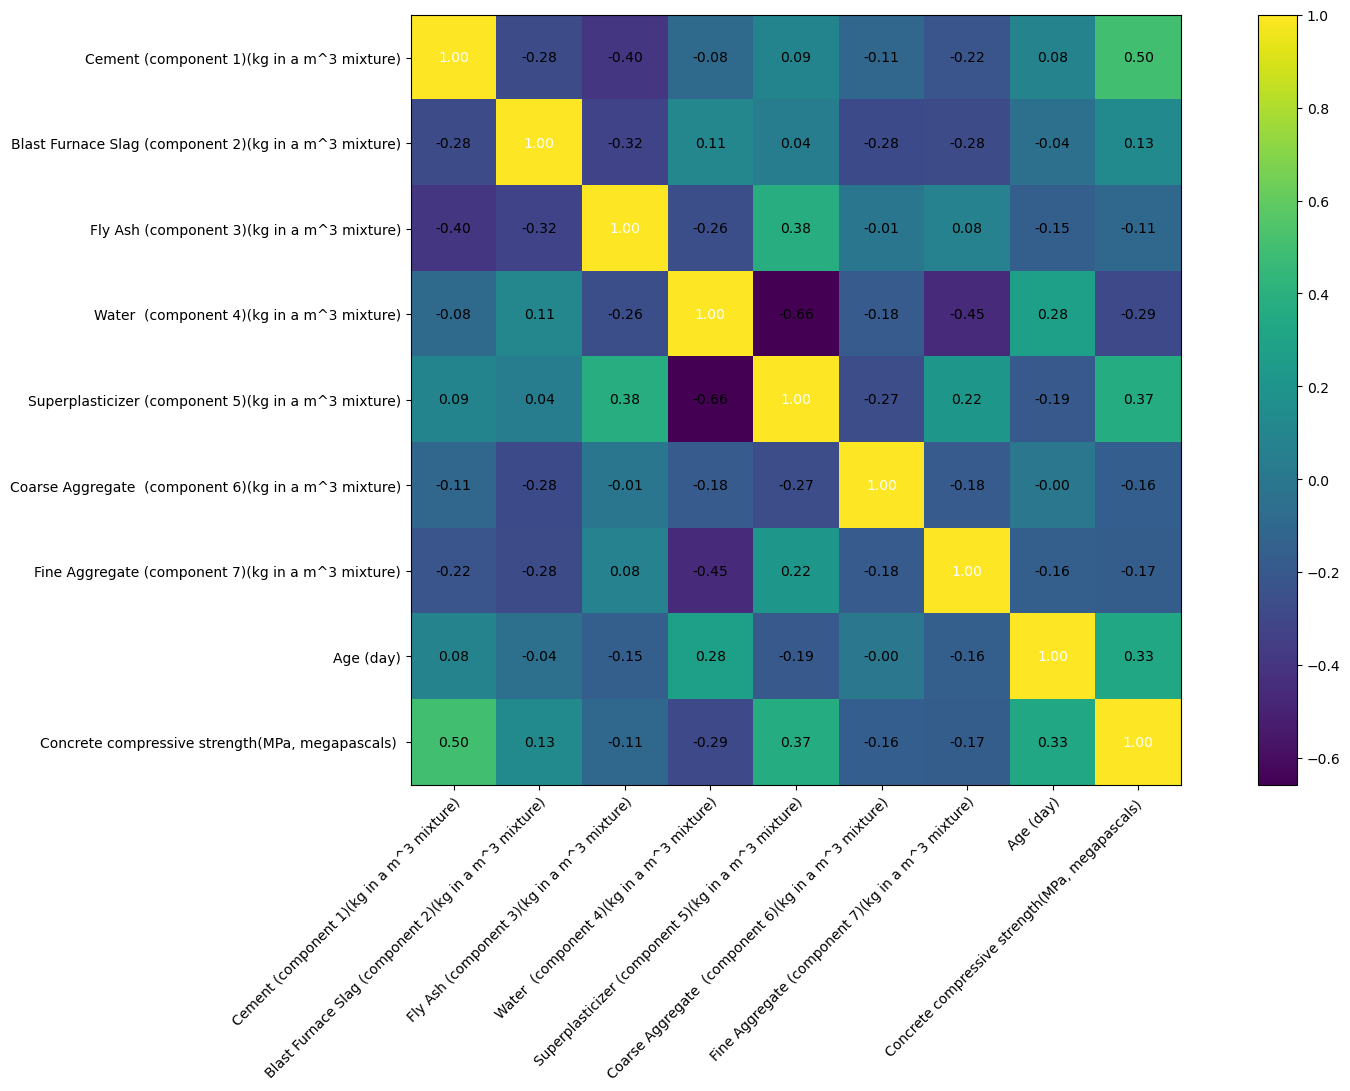

In [38]:
cm = np.corrcoef(concreteData[headers].values.T)
gm = heatmap(cm, row_names=headers, column_names=headers, figsize=(20,10))
plt.show()

In [39]:
concreteData_np = concreteData.to_numpy()
concreteData_np.shape

(1030, 9)

In [40]:
x = concreteData_np[:, :-1]
y = concreteData_np[:,-1:]

print(x.shape)
print(y.shape)

(1030, 8)
(1030, 1)


In [41]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=42)

In [42]:
print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)

(824, 8)
(824, 1)

(206, 8)
(206, 1)


In [43]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [44]:
X_train_tr = torch.from_numpy(X_train)
X_test_tr = torch.from_numpy(X_test)
y_train_tr = torch.from_numpy(y_train)
y_test_tr = torch.from_numpy(y_test)

In [45]:
batch_size = 16
epochs = 2000
lr = .001
epsilon = .0001

In [46]:
x_means = X_train_tr.mean(0, keepdim=True)
x_deviations = X_train_tr.std(0, keepdim = True) + epsilon

In [47]:
train_ds = TensorDataset(X_train_tr, y_train_tr)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [48]:
def training_loop(N_epochs, model, loss_fn, opt):
    for epoch in range(N_epochs):
        for xb, yb in train_dl:
            y_pred = model(xb)
            loss = loss_fn(y_pred, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

        if (epoch+1) % 20 == 0:
            print(f'loss = {loss} at epoch {epoch}')

In [49]:
class Linear(nn.Module):
    def __init__(self, x_means, x_deviations):
        super().__init__()
        self.x_means = x_means
        self.x_deviations = x_deviations
        self.linear = nn.Linear(8,1)


    def forward(self, x ):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear(x)
        return torch.round(x)


class MLP_Net(nn.Module):
    ## init the class
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(8, 3)
        self.act1    = nn.ReLU()
        self.linear2 = nn.Linear(3, 1)
        self.dropout = nn.Dropout(0.25)
        
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        y_pred = self.linear2(x)
        
        ## return torch.round( y_pred )
        return y_pred
    
class DL_Net(nn.Module):
    ## init the class
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(8, 5)
        self.act1    = nn.ReLU()
        self.linear2 = nn.Linear(5, 3)
        self.act2    = nn.ReLU()
        self.linear3 = nn.Linear(3, 1)
        self.dropout = nn.Dropout(0.25)
        
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        ## x = self.dropout(x)
        y_pred = self.linear3(x)
        
        ## return torch.round( y_pred )
        return y_pred

In [50]:
model = DL_Net(x_means, x_deviations)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = F.mse_loss

In [51]:
training_loop(epochs, model, loss_fn, optimizer)

loss = 225.3953094482422 at epoch 19
loss = 181.22312927246094 at epoch 39
loss = 80.11192321777344 at epoch 59
loss = 36.60701370239258 at epoch 79
loss = 52.47150421142578 at epoch 99
loss = 76.95272827148438 at epoch 119
loss = 141.9529266357422 at epoch 139
loss = 26.573637008666992 at epoch 159
loss = 167.9789581298828 at epoch 179
loss = 105.3714370727539 at epoch 199
loss = 56.6834831237793 at epoch 219
loss = 129.51904296875 at epoch 239
loss = 28.607505798339844 at epoch 259
loss = 54.46394348144531 at epoch 279
loss = 21.9095401763916 at epoch 299
loss = 20.12615394592285 at epoch 319
loss = 36.241912841796875 at epoch 339
loss = 50.91486358642578 at epoch 359
loss = 14.572250366210938 at epoch 379
loss = 57.87481689453125 at epoch 399
loss = 53.71961975097656 at epoch 419
loss = 29.25172233581543 at epoch 439
loss = 8.689455032348633 at epoch 459
loss = 24.934999465942383 at epoch 479
loss = 56.004539489746094 at epoch 499
loss = 65.34283447265625 at epoch 519
loss = 41.6154

In [52]:
y_pred_test = model(X_test_tr)

In [53]:
y_pred_test.shape

torch.Size([206, 1])

In [54]:
print( "Testing R**2: ", r2_score(  y_test_tr.numpy(),  y_pred_test.detach().numpy()     )  ) 


Testing R**2:  0.8371323688515839


In [57]:
dummy_input = torch.rand (1, 8).to("cpu")
onnx_path = "onnx_model.onnx"

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    verbose=False,
    input_names=['input'],
    output_names=['output']
)

print(f"Model exported to {onnx_path}")

Model exported to onnx_model.onnx


In [58]:
#load model
onnx_model = onnx.load(onnx_path)

#create runtime session
ort_session = onnxruntime.InferenceSession(onnx_path)

#fill with dummy data
input_data = dummy_input.cpu().numpy()

#run model with ONNX runtime
ort_inputs={ort_session.get_inputs()[0].name: input_data}
ort_outputs=ort_session.run(None, ort_inputs)
print("ONNX Runtime outputs", ort_outputs)

ONNX Runtime outputs [array([[3.1087499]], dtype=float32)]
